# Neural Networks for Data Science Applications
## Homework 1: Evaluating the calibration of a DL model

**Name**: *Braulio Villalobos-Quirós*

**Matricola**: *1999250*

Upload the completed notebook **before 14/11/2022 at 23:59** on the Google Classroom page.

In [ ]:
#Better run this to avoid mistakes with matplotlib versioning
!pip install matplotlib --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras 
import tensorflow_probability as tfp
from tensorflow import keras

In [ ]:
# To ensure reproducible results (as much as possible)
tf.keras.utils.set_random_seed(1234)

### Overview

The homework concerns training and evaluating the calibration of a neural network. It is divided into a small series of exercises: **the maximum mark (for the purpose of the exam) is 5**, but the total sum of points is 5.5, so you are allowed a margin of error. **Completing succesfully everything will result in a mark of 5+**.

🟥 The homework must be completed *using TensorFlow*. Do not use NumPy or anything else (with one exception in Exercise 5).

Below a brief description of the exercises; please read everything carefully at least once.

1.   **Exercise 1** (1 point): training a neural network on the provided dataset.
2.   **Exercise 2 and 3** (2 points): draw a *confidence histogram* and a *reliability diagram* (see instructions).
3.   **Exercise 4** (0.5 points): compute the *expected calibration error* (ECE).
3.   **Exercise 5** (1 point): implement the *multi-class focal loss* and re-check calibration.
4.   **Exercise 6** (1 point): implement a simple *conformal prediction* (CP) strategy (see instructions below).





## Data loading

The dataset we use is a well-known toy multiclass dataset concerning wine quality: https://archive.ics.uci.edu/ml/datasets/wine+Quality

We preprocess the original quality index into three classes (low, medium, and high quality), similarly to this notebook that you can check for more information about the dataset: https://www.kaggle.com/code/mgmarques/wines-type-and-quality-classification-exercises

In [ ]:
!wget --quiet https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv

In [ ]:
def load_data():
  """ Load and preprocesses the wine dataset.
  Returns:
    - X_train, X_test, y_train, y_test [tf.Tensor]: train and test input/output matrices.
  """
  import pandas as pd
  from sklearn.model_selection import train_test_split
  from sklearn.preprocessing import StandardScaler, MinMaxScaler
  
  data = pd.read_csv('winequality-white.csv', sep=';')
  data['quality_label'] = data.quality.apply(lambda q: 0 if q <= 5 else 1 if q <= 7 else 2)
  data = data.dropna() # Remove NAs
  del data['quality']  # Drop the original label
  X, y = data.values[:, :-1], data.values[:, -1]
  X = StandardScaler().fit_transform(X) # Normalize (we are "cheating" by also using the test data)
  X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
  return tf.constant(X_train), tf.constant(y_train), tf.constant(X_test), tf.constant(y_test)

In [ ]:
X_train, y_train, X_test, y_test = load_data()

In [ ]:
# Check some details about the dataset. You are free to add any additional pre-processing to understand it better.
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Number of classes: {tf.reduce_max(y_train) + 1}')

Shape of X_train: (3673, 11)
Shape of y_train: (3673,)
Number of classes: 3.0


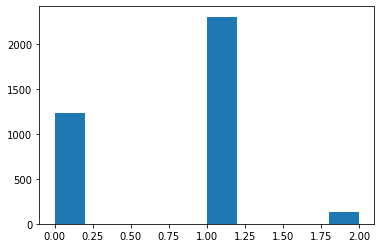

In [ ]:
# This is highly unbalanced by default
_ = plt.hist(y_train)

In [ ]:
tf.unique_with_counts(y_train,
                      out_idx=tf.dtypes.int32,
                      name=None)

UniqueWithCounts(y=<tf.Tensor: shape=(3,), dtype=float64, numpy=array([1., 0., 2.])>, idx=<tf.Tensor: shape=(3673,), dtype=int32, numpy=array([0, 0, 0, ..., 1, 0, 2], dtype=int32)>, count=<tf.Tensor: shape=(3,), dtype=int32, numpy=array([2308, 1230,  135], dtype=int32)>)

*************
We appreciate 2 important things: 

* Confirm in another way that we're dealing with a multiclass classification problem as we have 3 classes.
* The training examples aren't necessarily balanced as we have almost twice   of the training examples of class 2 (2308) than those from class 1 (1230). Additionally, we have just 135 training observations from class 3. This unbalanced number of observations **might** translate into an issue that we must address. 
*************

In [ ]:
# Baseline accuracy
from sklearn.dummy import DummyClassifier
DummyClassifier().fit(X_train, y_train).score(X_test, y_test)

0.6285714285714286

### Exercise 1: Train a neural network model (1 point)

Define, train, and test a neural network for the provided dataset.

☝ You are free to make any modelling choice (e.g., activation function), provided the result makes sense.

✅ **Completion requirement**: print on screen the test accuracy of the network. Comments are appreciated.

####**PLEASE IGNORE THE FOLLOWING CODE CHUNK** since it correpsonds to the question 5 but I had to put it here so that the function training_net_network can be defined.

In [ ]:
'''
In order to run the training_net_network
'''
class FocalLoss(tf.keras.losses.Loss):
  # TODO: complete implementation

  def __init__(self,gamma):
    super(FocalLoss, self).__init__()
    self.gamma = gamma

  def call(self, y_true, y_pred):
    return compute_focal_loss(y_true, y_pred, self.gamma)
  
def compute_focal_loss(y_true, y_pred, gamma):
  '''
  Function that implements the computation of the Focal Loss. 
  Focal reduces the loss for the observations that are correctly classified
  while gives a higher importance to the hard-to-classify observations, as it
  increases the loss for the observations that are incorrectly classified.

  p_t corresponds to the probability the model gives to the correct class
  '''
  #Guarantee stability of logarithm in case of 0
  epsilon = 0.001
  
  #Make sure the y_pred is a tensor
  y_pred = tf.convert_to_tensor(y_pred)
  #Making sure the y_true tensor is of the same type as the y_pred
  y_true = tf.cast(y_true, tf.int32)
  
  #We retrieve the probability of the correct class, for each observation
  p_t = tf.gather(y_pred,y_true,batch_dims=1)
  
  l = ((1-p_t) ** gamma) * tf.math.log(p_t + epsilon)
  return -l
  #return tf.math.multiply(-tf.math.log(p_t+epsilon),tf.math.pow((1-p_t),gamma))

## [Q1] Defining the Neural Network

In [ ]:
# TODO: define a suitable neural network.
'''
The following neural network (NN) will be used through the entire assignment. 
Changes regarding the optimizer or loss function will be carried out, however
the basis neural network will always be same. 

The net NN isn't the product of exhaustive thinking about the network's 
architecture but 2 decisions were taken: 
1) As calibration issues tend to appear as the network gets more complex and deeper,
we try to create a deeper-than-needed network while preserving a small training 
time. 
2) We put ReLU activation functions on the first two layers while the last layer
is composed of three neurons with a softmax activation. Such that the output of 
final layer is already made up of probabilities. 
'''
net = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation = keras.activations.relu),
    tf.keras.layers.Dense(50, activation = keras.activations.relu),
    tf.keras.layers.Dense(3, activation = keras.activations.softmax)
])

## [Q1] Training the Neural Network


We train the network using already built-up functions. However, we can carry out 
the training by using for loops.

In this case, we decide to use the Cross Entropy Loss, coupled with an 
Sthochastic Gradient Descent (SGD) optimizer. 
Two important considerations to make: 

1) We also used the Adam optimizer, which showed accelerated convergence with 
respect to SGD.




In [ ]:
def training_net_network(X_train_i,y_train_i,loss_i,optimizer_i,learning_rate_SGD = 0.01, gamma_focal=2, epochs_i=100):
  '''
  Function that compiles the just defined net network according to the selected
  loss between 2 options: Sparse Categorical Cross Entropy Loss or Focal Loss (
  implemented in point 5 of this assignment) and the selected optimizer out of
  2 options: Stochastic Gradient Descent or Adam optimizer.
  '''
  tf.keras.utils.set_random_seed(1234)
  #Validate if parameters of selected Optimizer and Loss were correctly written
  valid_optim = {'SGD', 'Adam'}
  valid_loss = {'CrossEntropy', 'Focal'}
  
  if loss_i not in valid_loss:
      raise ValueError("Loss: loss_i must be one of %r." % valid_loss)
  if optimizer_i not in valid_optim:
      raise ValueError("Optimizer: optimizer_i must be one of %r." % valid_optim)
  
  #Define Loss according to selection
  if loss_i == 'CrossEntropy': 
    s_loss = tf.keras.losses.SparseCategoricalCrossentropy()
  else: 
    s_loss = FocalLoss(gamma_focal)
  
  #Define Optimizer according to selection
  if optimizer_i == 'SGD':
    s_optim = tf.keras.optimizers.SGD(learning_rate_SGD)
    s_metric = tf.keras.metrics.SparseCategoricalAccuracy()
  else:
    s_optim = tf.keras.optimizers.Adam()
    s_metric = tf.keras.metrics.MeanSquaredError()
  
  #Define the compilation 
  net.compile(loss = s_loss,
              optimizer = s_optim,
              metrics = s_metric
  )
  
  tf.print(f'Network successfully compiled with {loss_i} loss and {optimizer_i} optimiizer!')
  
  #Train Network!!
  history_o = net.fit(X_train_i, y_train_i, epochs=epochs_i, verbose = 0)
  tf.print(f'Network successfully trained!')
  return history_o

Now that we have defined the function to compile and train the network we defined in previous steps, we proceed to use it and train the Neural Network with our training set.

In [ ]:
#We compile the just defined net network, in this case with Sparse Categorical Cross Entropy and SGD optimizer.
history = training_net_network(X_train, y_train, 'CrossEntropy', 'SGD',epochs_i = 1000)

Network successfully compiled with CrossEntropy loss and SGD optimiizer!
Network successfully trained!


We visualize the Loss and Accuracy of the NN we have just trained. As it desired, the Loss decreases and the accuracy increases as the number of epochs increases. Apart from the obvious, 2 key points: 

1) Around the epoch 800, we obtain a nearly perfect accuracy. Therefore it might not be necessary to run for 1000 epochs. 

2) However, we decided to run until 1000 epochs and take this trained model to continue with the rest of the assignment because of the calibration problem that we are about to analyze. We will see that Neural Networks trained with Cross Entropy Loss, tend to push the probabilities towards 1 and as a result, calibration problems may arise. For this reason, we decide to run the NN for such a high number of epochs. 

Text(0.5, 1.0, 'Net Model with SGD and Cross Entropy - Training Phase')

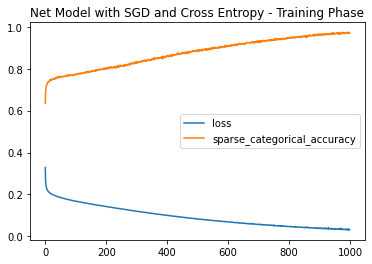

In [ ]:
import pandas as pd
pd.DataFrame(history.history).plot()
plt.title("Net Model with SGD and Cross Entropy - Training Phase")

In [ ]:
#Simple exploration of our network
net.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 100)               1200      
                                                                 
 dense_4 (Dense)             (None, 50)                5050      
                                                                 
 dense_5 (Dense)             (None, 3)                 153       
                                                                 
Total params: 6,403
Trainable params: 6,403
Non-trainable params: 0
_________________________________________________________________


In [ ]:
my_vect = net.predict(X_test)
my_vect

39/39 [==============================] - 0s 2ms/step


array([[4.9053445e-01, 5.0946343e-01, 2.1557237e-06],
       [5.0603453e-02, 8.5759318e-01, 9.1803312e-02],
       [8.5096449e-01, 1.4903535e-01, 5.8489242e-08],
       ...,
       [2.6155077e-03, 9.9726534e-01, 1.1908926e-04],
       [5.4958224e-01, 4.5040941e-01, 8.3553214e-06],
       [1.5834766e-02, 9.8414385e-01, 2.1346717e-05]], dtype=float32)

## [Q1] Testing the Neural Network

In [ ]:
# TODO: test the neural network and print the result on screen.
#tf.random.set_seed(26)
my_test = net.evaluate(X_test, y_test)
#We save the accuracy to then plot it in the confidence histogram
avg_accuracy = my_test[1]
print(avg_accuracy)

39/39 [==============================] - 0s 2ms/step - loss: 0.3507 - sparse_categorical_accuracy: 0.7445
0.7444897890090942


#### Short comment about the accuracy

1) After 1000 epochs, considering a SGD with a learning rate of 0.01 and a Cross Entropy Loss, we achieve around 78% of accuracy. This is highest than the dummy classifier at the beginning of the document. 



In [ ]:
def make_predictions(X_test_inp):
  '''
  Function to make predictions using our previously defined net and the testing set.
  
  The output of this function will be a tensor made up of the probabilities that our NN gives to each class
  and test observation. For this reason, each row will sum up to 1. We will use this tensor throught the entire assignment.
  '''
  return net.predict(X_test_inp)

In [ ]:
#Vector of probabilities for predictions that will be used later
my_vect = make_predictions(X_test)
my_vect[:5]

39/39 [==============================] - 0s 2ms/step


array([[4.9053445e-01, 5.0946343e-01, 2.1557237e-06],
       [5.0603453e-02, 8.5759318e-01, 9.1803312e-02],
       [8.5096449e-01, 1.4903535e-01, 5.8489242e-08],
       [1.6910540e-01, 8.3089393e-01, 7.0882822e-07],
       [8.0983245e-01, 1.9016758e-01, 3.4244067e-08]], dtype=float32)

### Exercise 2: Confidence histogram of the network (1 point)

🟥 Before starting, read carefully at least Sections 1 and 2 of the following paper: [On the calibration of modern neural networks](https://arxiv.org/abs/1706.04599) (which we also discussed in class). We will refer to the paper as (Guo et al., 2017).

The purpose of this exercise is to replicate a confidence histogram *computed over the test set*, which is Fig. 1 in (Guo et al., 2017), top-left figure. The plot should include:
1. The distribution of the network's confidence (corresponding to **the highest output probability**);
2. The average accuracy of the network;
3. The average confidence of the network.

✅ **Completion requirement**: plot the correct figure. Please include a readable legend and captions on the axes.

In [ ]:
# To start: this is the number of bins for the histogram and the corresponding values. You are free to modify the number of bins.
num_bins = 10
bins = tf.linspace(start=0.0, stop=1.0, num=num_bins)
print(bins)

tf.Tensor(
[0.         0.11111111 0.22222222 0.33333334 0.44444445 0.5555556
 0.6666667  0.7777778  0.8888889  1.        ], shape=(10,), dtype=float32)


We start by defining two functions that will allow us to build the Confidence Histograms and later on the Realibility plots.

* The gather_indexes_f function creates a 2d tensor made up of the sequence of numbers until the length of the testing set and the indexes, for each observation on the test set, where there's the highest probability given by our model. In other words, it allow us to identify which is the class assigned by the model to each observation, based on the highest probability.

* The pred_confidence function allows us to extract components of a tensor, given another tensor of indexes. We will use it to extract the class predicted by our model to each observation. 

In [ ]:
def gather_indexes_f(y_test_inp, predictions):
  '''
  Function that creates a (1225,2) tensor that is the used by pred_confidence function
  to retrieve the highest probability prediction for each observation. 
  '''
  #Create a tensor of range from 0 to the number of elements in the y_test_inp tensor
  first = tf.cast(tf.range(0,y_test_inp.shape), tf.int32)
  #Retrieve the index of the class predicted with highest probability (argmax) for each observation
  second = tf.cast(tf.constant(tf.argmax(predictions,1)), tf.int32)

  #Stack both tensors in 1 single tensor that is used then as indexer
  return tf.stack([first, second], axis=1)

def pred_confidence(predictions, max_indexes):
  #Retrieve for each observation in the predictions the one predicted with the highest probability.
  return tf.gather_nd(predictions,max_indexes)

In [ ]:
#Create an auxiliary tensor
uyuy = gather_indexes_f(y_test, my_vect)
#Create tensor of the probability (which will of course be the highest prob for each observation) assigned to the class assigned to each observation.
piou = pred_confidence(my_vect,uyuy)

In [ ]:
#Compute the average confidence to then visualize it in the Confidence Histogram
avg_confidence = np.mean(piou)
avg_confidence

0.78215617

In [ ]:
#ERASE
layer = tf.keras.layers.Discretization(bin_boundaries=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.])
#indices tensor has number of bin to which each prediction belongs to.
indices_conf = layer(piou)

In [ ]:
def conf_diagram(indices):
  '''
  Function that takes the indices tensor and creates the final tensor that we will use to build the Confidence Histogram
  '''
  rrr = []
  for i in range(10):
    chosen_bin = tf.constant(tf.experimental.numpy.where(indices == i)[0], dtype=tf.int64)
    length_test = len(chosen_bin)
    if length_test == 0:
      rrr.append(0)
    else:
      rrr.append(length_test)
  new_rrr = tf.stack(rrr)
  new_rrr_t= new_rrr/len(indices)

  return new_rrr_t

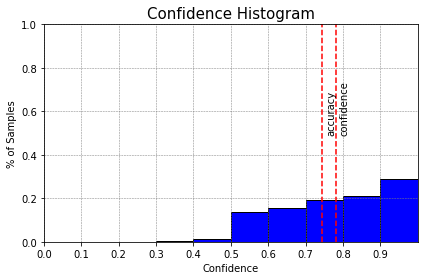

In [ ]:
# TODO: plot the confidence histogram.
a = conf_diagram(indices_conf)
#b = xxx['accuracies']
ind = np.arange(0,1,0.1)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(x=ind, height=a, width = 0.1, label = 'confidence' ,align='edge', color = "blue", edgecolor= 'black')
#ax.bar(x=ind, height=b, width=0.09, label = 'accuracy' ,align='edge', color = "pink", alpha = 0.5, edgecolor= 'pink')
#plt.axline((0, 0), slope=1, color="black", label = 'perf calibration', linestyle=(0, (5, 5)))
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)
plt.xticks(ind)
plt.title("Confidence Histogram", size = 15)
plt.xlabel("Confidence")
plt.ylabel("% of Samples")
plt.grid(True, color = "grey", linewidth = "0.5", linestyle = "--")
plt.axvline(x=avg_accuracy,color='red', linestyle='--')
plt.annotate("accuracy",rotation=90,xy=(avg_accuracy+0.01, .5))
plt.axvline(x=avg_confidence,color='red', linestyle='--')
plt.annotate("confidence",rotation=90,xy=(avg_confidence+0.01, .5))

plt.tight_layout()
plt.show()

**Insights of the previous histogram**: 

1) We can see how the NN appears to be fairly well calibrated as there isn't a small number of bins (1 or 2 for instance) that concentrate the vast majority of predictions. 

2) It is expected to have some bins without observations, in this case the first 3 bins because we are in a multi class classificaiton problem with 3 classes. Therefore it isn't possible that for one observation the hightest probability predicted by the NN is below 0.33. 

3) Another not definite but at least extra fact that gives us a slight sense of the absence of huge calibration problems is given by the relative closeness between the average accuracy and average confidence (pictured with the red dashed vertical lines). This means that as a whole the average confidence with which the model makes predictions is close to the average accuracy it has. However, this conclusion is supported better by analyzing the following Reliability Plot, where we can make this analysis but for each bin and not for the model as a whole. 

### Exercise 3: Reliability diagrams (1 point)

This is similar to exercise 2, but you need to plot a **reliability diagram**, which is the bottom-left figure in Fig. 1 from (Guo et al., 2017). For this figure you need:

1. The histogram of the average accuracy of the network for each bin.
2. A superimposed histogram of the average confidence for each bin.
3. A diagonal line showing perfect calibration.

☝ **Hint**: the `Discretization` layer from TF may be useful: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Discretization

🟩 **Completion requirement**: plot the correct figure. Please include a readable legend and captions on the axes.


We define the following function that will allow us to build the Reliability Diagrams. Each step is commented. 

In [ ]:
# TODO: plot the reliability diagram.
#

def reliability_preprocess(true_labels, predicted_labels, confidence_array, num_bins = 10):
  '''
  The reliability_preprocess function allows us to retrieve some metrics for each bin that are formed when we use our trained NN to predict. 
  The logic behind the function is that we classify the predictions in 10 bins based on the confidence with which they were made. Once each
  observation is assigned to each bin, we compute some metrics for each bin.

  The function takes the following inputs:
  * true_labels: tensor with the true_labels for each observation on the test set. 
  * predicted_labels: tensor with class assigned by our NN to each observation.
  * confidence_array: tensor with the probabilities given by our NN to the predicted class for each observation.
  The function will output a dictionary where for each bin the average accuracy, confidences, counts are given. 
  '''
  tf.keras.utils.set_random_seed(1234)
  bin_size = 1.0/num_bins
  bins = np.linspace(0.0,1.0,num_bins)

  #Instantiate layer using Discretization layer of tf. This layer will output a tensor with the number of the bin to which each observation belongs to
  #based on the confidence with which its prediction was made. The bins are made by the bin_boundaries parameter of the Discretization.
  layer = tf.keras.layers.Discretization(bin_boundaries=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.])
  #indices tensor has number of bin to which each prediction belongs to.
  indices = layer(confidence_array)

  #Create some lists to store the 3 metrics that are computed **for each** bin
  bin_accuracies = []  #array for avg accuracies in each bin
  bin_confidences = []  #array for avg confidences in each bin
  bin_counts = []  #array counting how many predictions fall on each bin

  #for each bin
  for b in range(num_bins):
    #Create a tensor in which we select all observations that belong to the **same bin**
    chosen_bin = tf.constant(tf.experimental.numpy.where(indices == b)[0], dtype=tf.int64) #selects all observations that belong to the same bin

    #Clause to avoid nan in vectors
    if len(chosen_bin)>0:
      #compute average accuracy of the bin by comparing the true and predicted labels.
      #We extract from the true labels and the predicted labels those predictions that belong to the same bin, we then compare if they're the same, 
      #we obtain a boolean tensor to which we compute its mean and obtain the average accuracy for a particular bin.
      bin_accuracies.append(tf.reduce_mean(tf.cast(tf.equal(tf.cast(tf.gather(true_labels,chosen_bin),tf.int64),tf.gather(predicted_labels,chosen_bin)), tf.float32)))
    
      #compute average confidence of the bin. We apply the same logic as for the average accuracy 
      bin_confidences.append(tf.reduce_mean(tf.gather(confidence_array,chosen_bin)))
    
      #count how many elements are within each bin. Just take the length of the chosen_bin tensor
      bin_counts.append(len(chosen_bin))
    else:
      #If there's not a single prediction that belong to a bin, append 0 to the list
      bin_accuracies.append(0)
      bin_confidences.append(0)
      bin_counts.append(0)

  #Create tensors by stacking the lists
  bin_accuracies_t = tf.stack(bin_accuracies)
  bin_confidences_t = tf.stack(bin_confidences)
  bin_counts_t = tf.stack(bin_counts)
  #Compute average accuracy and confidence of the whole network
  avg_network_accuracy = tf.reduce_mean(bin_accuracies)
  avg_acc = tf.reduce_sum(tf.math.multiply(tf.cast(bin_accuracies,tf.float32), tf.cast(bin_counts,tf.float32))) / tf.cast(tf.reduce_sum(bin_counts),tf.float32)
  avg_conf = tf.reduce_sum(tf.math.multiply(tf.cast(bin_confidences,tf.float32), tf.cast(bin_counts,tf.float32))) / tf.cast(tf.reduce_sum(bin_counts),tf.float32)

  
  return { "accuracies": bin_accuracies_t, 
             "confidences": bin_confidences_t, 
             "counts": bin_counts_t, 
             "bins": bins,
             "avg_accuracy": avg_acc,
             "avg_confidence": avg_conf
          }

In [ ]:
pred_labels = tf.argmax(my_vect, axis=-1)
pred_labels

<tf.Tensor: shape=(1225,), dtype=int64, numpy=array([1, 1, 0, ..., 1, 0, 1])>

In [ ]:
xxx = reliability_preprocess(y_test, pred_labels, piou, num_bins = 10)
xxx 

{'accuracies': <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([0.        , 0.        , 0.        , 0.33333334, 0.64285713,
        0.62352943, 0.64021164, 0.73504275, 0.7807692 , 0.8450704 ],
       dtype=float32)>,
 'confidences': <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([0.        , 0.        , 0.        , 0.38820437, 0.4670274 ,
        0.54914296, 0.6491297 , 0.75248116, 0.8506053 , 0.949748  ],
       dtype=float32)>,
 'counts': <tf.Tensor: shape=(10,), dtype=int32, numpy=array([  0,   0,   0,   3,  14, 170, 189, 234, 260, 355], dtype=int32)>,
 'bins': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
        0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
 'avg_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.7444898>,
 'avg_confidence': <tf.Tensor: shape=(), dtype=float32, numpy=0.78215617>}

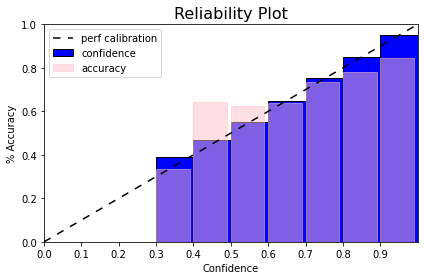

In [ ]:
a = xxx['confidences']
b = xxx['accuracies']
ind = np.arange(0,1,0.1)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(x=ind, height=a, width = 0.1, label = 'confidence' ,align='edge', color = "blue", edgecolor= 'black')
ax.bar(x=ind, height=b, width=0.09, label = 'accuracy' ,align='edge', color = "pink", alpha = 0.5, edgecolor= 'pink')
plt.axline((0, 0), slope=1, color="black", label = 'perf calibration', linestyle=(0, (5, 5)))
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)
plt.xticks(ind)
plt.title("Reliability Plot", size = 16)
plt.xlabel("Confidence")
plt.ylabel("% Accuracy")
plt.legend(loc="upper left")

plt.tight_layout()
plt.show()

🛑 Before moving to the next exercise, answer (in a short sentence) the following question.

**Question**: what does the previous diagrams tell you about the calibration of the neural network?

1) The NN appears **not** to have huge problems of miscalibration although it is not perfectly calibrated (which isn't in fact possible at all). However the NN shows some miscalibration in the 0.8-0.9 and 0.9-1 bins as the average accuracy of the predictions made with confidences within those bins, are lower and therefore don't match the avg confidences. 

2) This conclusion is also **supported** by the Confidence Histogram of Exercise 2 where we can see a more widely spreaded distribution of the predictions according to the confidence with which they were made, instead of highly skewed or concentrated distribution.

3) If our network would present miscalibration problems, we would expect a Confidence histogram with a concentrated distribution (generally on the high confidences) and a reliability plot that shows bins with an average accuracy considerably lower than the avg confidences.

### Exercise 4: Expected calibration error, ECE (0.5 points)

For this exercise, you need to compute and print on screen the ECE, which is Eq. (3) from (Guo et al., 2017).

☝ **Hint(s)**: you should have computed almost everything already for Exercise 3. If you have NaN issues, you may want to check for empty bins.

🟩 **Completion requirement**: print the ECE.

We compute the Expected Calibration Error by applying the following formula: 

ECE = $\sum_{m=1}^{M}  \frac{\rvert{B_m}\lvert}{n}\rvert acc(B_m) - conf(B_m)\lvert$

In [ ]:
# TODO: compute and print the ECE for the network.
def compute_ece(input_dict):
  '''
  Computation of Expected Calibration Error (ECE) is implemented by this function
  
  Computation is carried out in steps for better understanding and explainability, although it's possible to do a one liner. 
  '''
  first_term = tf.cast(input_dict['counts']/tf.reduce_sum(input_dict['counts']),tf.float32)
  second_term = tf.cast(tf.math.abs(tf.math.subtract(input_dict['accuracies'],input_dict['confidences'])),tf.float32)
  return (tf.reduce_sum(tf.math.multiply(first_term,second_term)))

In [ ]:
ece = compute_ece(xxx)
ece

<tf.Tensor: shape=(), dtype=float32, numpy=0.062331386>

The computed Expected Calibration Error is 0.06.

### Exercise 5: Calibrating with the focal loss (1 point)

🟥 Before proceeding, read carefully the following paper: [Calibrating Deep Neural Networks using Focal Loss](https://proceedings.neurips.cc/paper/2020/hash/aeb7b30ef1d024a76f21a1d40e30c302-Abstract.html). We'll refer to it as (Mukhoti et al., 2020).

The task of this exercise is to train again the neural network from before, using the Focal Loss (Section 4 in (Mukhoti et al., 2020)) instead of the cross-entropy:

\begin{equation}
L(y, \hat{y}) = - (1-\hat{y}_c)^\gamma \log \hat{y}_c
\end{equation}

where $\hat{y}$ is the vector of predictions from the network, $c$ is the index of the correct class ($y_c == 1$), $\gamma > 0$ is a hyper-parameter. For $\gamma=0$, this reduces to the cross-entropy.

☝ In order to implement a new loss function in TF, you need to subclass [tf.keras.losses.Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses/Loss). Read carefully the link.

🟩 **Completion requirement**: complete the `FocalLoss` implementation below. Instantiate a new network, train with the new focal loss, and check the resulting confidence histogram, reliability diagram, and ECE.


#### Quick Theoretical summary of Cross Entropy Loss vs Focal Loss

I find worthy to point out the main differences between Cross Entropy and Focal Loss. So consider that 

$CE(p_t) = -log(p_t)$

$FL(p_t) = - (1-p_t)^{\gamma} log(p_t)$ 

where p_t is the the probability that the model predicts for the ground truth class. In other words, it is the probability that our model gives to the correct class. 

If we analyze the following image, it is possible to see that

1) Why CE Loss pushes the model to be overconfident? When the model is predicting the ground truth with a prob of 0.6, the Cross Entropy Loss is around 0.5. For this reason, with the aim of reducing the loss, the model will try to predict the ground truth with higher probability as possibly, consequently pushing up the probability. For this reason, CE encourages the model to be highly confident about its ground truth predictions. 

2) On the other hand, Focal Loss will reduce the loss for those examples that are correctly classified, whereas it will increase the loss for those examples that are hard to classify. For instance, if the model predicts the correct class with 0.8 probability then the $log(p_t = 0.8)$ will push the loss down and it will also be pushed by the $(1-p_t)^{\gamma}$ term. On the opposite situation, the loss will be pushed up, therefore turning the model's attention mainly towards the examples that aren't correctly classified or classified with a low proability.

**Image upon which this summary is based on can be found in https://amaarora.github.io/2020/06/29/FocalLoss.html**


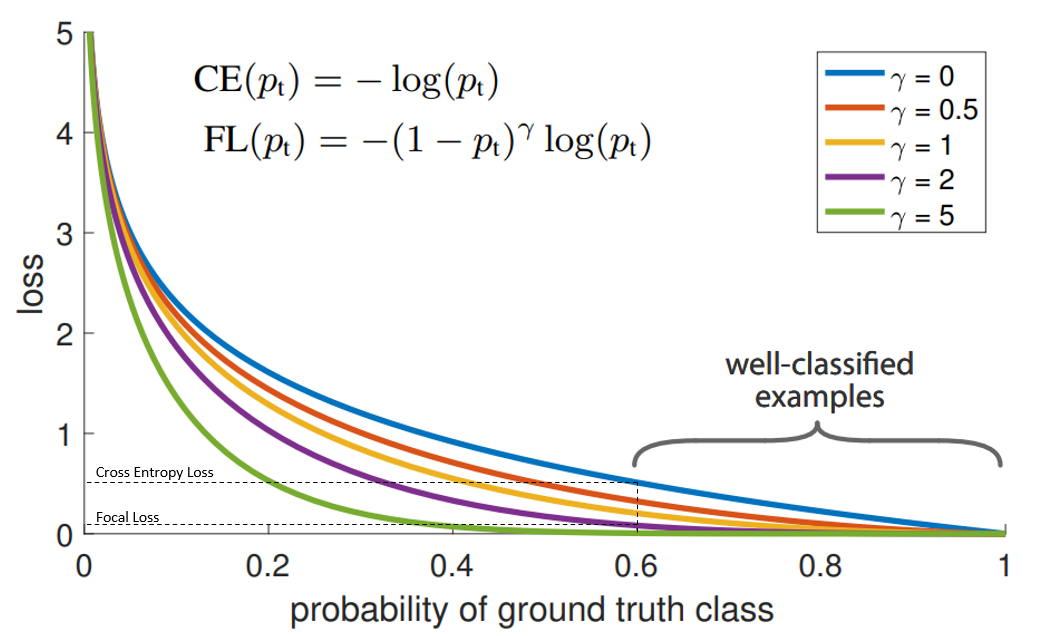

In [ ]:
class FocalLoss(tf.keras.losses.Loss):
  # TODO: complete implementation

  def __init__(self,gamma):
    super(FocalLoss, self).__init__()
    self.gamma = gamma

  def call(self, y_true, y_pred):
    return compute_focal_loss(y_true, y_pred, self.gamma)

In [ ]:
def compute_focal_loss(y_true, y_pred, gamma):
  '''
  Function that implements the computation of the Focal Loss. 
  Focal reduces the loss for the observations that are correctly classified
  while gives a higher importance to the hard-to-classify observations, as it
  increases the loss for the observations that are incorrectly classified.

  p_t corresponds to the probability the model gives to the correct class
  '''
  #Guarantee stability of logarithm in case of 0
  epsilon = 0.001
  
  #Make sure the y_pred is a tensor
  y_pred = tf.convert_to_tensor(y_pred)
  #Making sure the y_true tensor is of the same type as the y_pred
  y_true = tf.cast(y_true, tf.int32)
  
  #We retrieve the probability of the correct class, for each observation
  p_t = tf.gather(y_pred,y_true,batch_dims=1)
  
  l = ((1-p_t) ** gamma) * tf.math.log(p_t + epsilon)
  return -l

In [ ]:
# TODO: Train a second neural network with the FocalLoss object.
history_focal = training_net_network(X_train, y_train, 'Focal', 'SGD',epochs_i = 1000, gamma_focal=2)

Network successfully compiled with Focal loss and SGD optimiizer!
Network successfully trained!


Text(0.5, 1.0, 'Net Model with SGD and Focal Loss - Training Phase')

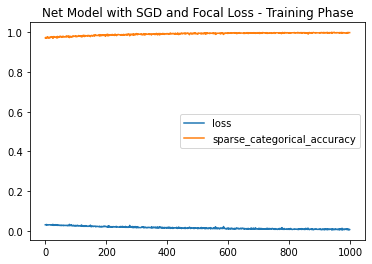

In [ ]:
import pandas as pd
pd.DataFrame(history_focal.history).plot()
plt.title("Net Model with SGD and Focal Loss - Training Phase")

In [ ]:
#We compute the average accuracy
my_test_focal = net.evaluate(X_test, y_test)
avg_accuracy_focal = my_test_focal[1]

39/39 [==============================] - 0s 6ms/step - loss: 0.5332 - sparse_categorical_accuracy: 0.7714


In [ ]:
my_vect_focal = net.predict(X_test)
my_vect_focal[:5]

39/39 [==============================] - 0s 4ms/step


array([[2.0285290e-01, 7.9714698e-01, 4.8337156e-08],
       [7.4184970e-03, 9.6399474e-01, 2.8586771e-02],
       [9.1429406e-01, 8.5705876e-02, 2.5989591e-11],
       [6.8155527e-02, 9.3184441e-01, 2.3712401e-10],
       [9.3516797e-01, 6.4832009e-02, 7.9680967e-12]], dtype=float32)

In [ ]:
uyuy_focal = gather_indexes_f(y_test, my_vect_focal)
piou_focal = pred_confidence(my_vect_focal,uyuy_focal)
pred_labels_focal = tf.argmax(my_vect_focal, axis=-1) 

In [ ]:
xxx_focal = reliability_preprocess(y_test, pred_labels_focal, piou_focal, num_bins = 10)

In [ ]:
# TODO: plot confidence histogram, reliability diagram, and print the ECE of the new network.

##### Confidence Histogram

In [ ]:
avg_confidence_focal = np.mean(piou_focal)
avg_confidence_focal

0.8667875

In [ ]:
#ERASE
layer = tf.keras.layers.Discretization(bin_boundaries=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.])
#indices tensor has number of bin to which each prediction belongs to.
indices_conf_focal = layer(piou_focal)

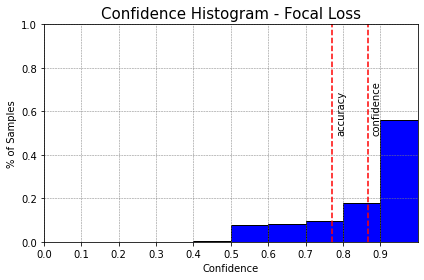

In [ ]:
a = conf_diagram(indices_conf_focal)
#b = xxx['accuracies']
ind = np.arange(0,1,0.1)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(x=ind, height=a, width = 0.1, label = 'confidence' ,align='edge', color = "blue", edgecolor= 'black')
#ax.bar(x=ind, height=b, width=0.09, label = 'accuracy' ,align='edge', color = "pink", alpha = 0.5, edgecolor= 'pink')
#plt.axline((0, 0), slope=1, color="black", label = 'perf calibration', linestyle=(0, (5, 5)))
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)
plt.xticks(ind)
plt.title("Confidence Histogram - Focal Loss", size = 15)
plt.xlabel("Confidence")
plt.ylabel("% of Samples")
plt.grid(True, color = "grey", linewidth = "0.5", linestyle = "--")
plt.axvline(x=avg_accuracy_focal,color='red', linestyle='--')
plt.annotate("accuracy",rotation=90,xy=(avg_accuracy_focal+0.01, .5))
plt.axvline(x=avg_confidence_focal,color='red', linestyle='--')
plt.annotate("confidence",rotation=90,xy=(avg_confidence_focal+0.01, .5))

plt.tight_layout()
plt.show()

##### Reliability Diagram

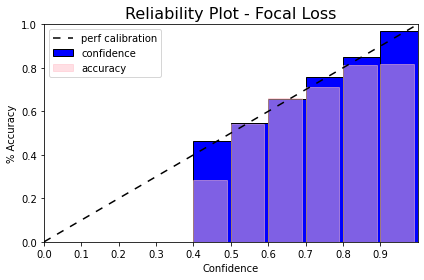

In [ ]:
a = xxx_focal['confidences']
b = xxx_focal['accuracies']
ind = np.arange(0,1,0.1)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(x=ind, height=a, width = 0.1, label = 'confidence' ,align='edge', color = "blue", edgecolor= 'black')
ax.bar(x=ind, height=b, width=0.09, label = 'accuracy' ,align='edge', color = "pink", alpha = 0.5, edgecolor= 'pink')
plt.axline((0, 0), slope=1, color="black", label = 'perf calibration', linestyle=(0, (5, 5)))
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)
#ax.legend([])
plt.xticks(ind)
plt.title("Reliability Plot - Focal Loss", size = 16)
plt.xlabel("Confidence")
plt.ylabel("% Accuracy")
plt.legend(loc="upper left")

plt.tight_layout()
plt.show()

##### Expected Calibration Error (ECE)

In [ ]:
ece_focal = compute_ece(xxx_focal)
ece_focal

<tf.Tensor: shape=(), dtype=float32, numpy=0.09571522>

🛑 Before moving to the next exercise, answer (in a short sentence) the following question.

**Question**: what can you tell about the calibration of this second neural network?

Training our model based on Focal Loss slightly worsens the calibration of the model. This can be seen 

* Firstly on the confidence histogram as the distribution is more concentrated in the upper bins (particularly in the last one) and therefore less spreaded. So more predictions were made with a very high confidence which can not necessarily be matched with a high accuracy. 
* Secondly and still on the confidence histogram and analyzing the model as a whole, we can see a greater difference between the average accuracy and average confidence of this model with respect to the model trained with the Cross Entropy Loss. This means that on average, the high confidence is more frequently *not* met by a high accuracy on this model than with respect to the Cross Entropy Loss Model.
* Thirdly the reliability plot shows a slightly greater gap between the avg accuracy and avg confidence on the last 2 bins. Moreover, the underconfidence showed by the model with CS in the lower bins, dissapeared with the FL. 
* Finally, the ECE is greater in the model with FL than with CS. In other words, the difference between the accuracy and confidence of the bins, weighted by the relative importance of the bin, is higher in the case of the FL than in the CS. 

This could happen because our model with CS was already very well calibrated. 

### Exercise 6: Conformal prediction (1 point)

🟥 Before proceeding, read **Section 1** from the following paper: [A Gentle Introduction to Conformal Prediction and Distribution-Free Uncertainty Quantification](https://arxiv.org/abs/2107.07511). We'll refer to it as (Angelopoulos and Bates, 2021). Note that this material *was not covered in class*.

CP can be understood as an alternative approach to calibration to quantify uncertainty of a model. In CP we take a trained classifier $f(x)$, and we transform it to a set-classifier, i.e., a classifier that outputs a set $\mathcal{C}(x)$ of possible classes. The set is guaranteed to satisfy:

\begin{equation}
P(y \in \mathcal{C}(x)) \ge 1 - \alpha
\end{equation}

where $\alpha$ is a hyper-parameter called the **error rate**, i.e., the probability that the correct class is inside the set is $1-\alpha$. For the purpose of this exercise, you need to implement a simple CP procedure which is described in Fig. 2 of (Angelopoulos and Bates, 2021).

☝ **Hints**: In practice, you would need a separate validation set. For the purpose of this exercise, you can use the previously defined test set for everything. For computing the **quantile**, you are allowed to use NumPy or TensorFlow Probability.

🟩 **Completion requirement**: Replicate the pseudocode from Fig. 2 of (Angelopoulos and Bates, 2021) in TF and apply it on the trained neural network. Plot a histogram showing the distribution of the sizes of the output sets, when the network is run on the entire test set.

In [ ]:
# Implement the CP procedure
def quantile_comput_conformal(y_pred, y_true, alpha=0.10):
  '''
  
  '''
  #Make sure the y_pred is a tensor
  y_pred = tf.convert_to_tensor(y_pred)
  #Make sure the y_true tensor is of the same type
  y_true = tf.cast(y_true, tf.int32)

  #Step #1: Get conformal scores
  #Retrieve the probability of the correct class, for each observation 
  p_t = tf.gather(y_pred, y_true, batch_dims = 1)

  #Compute conformal score
  conformal_score = 1-p_t

  #Step #2: Get adjusted quantile
  #Get the level to which the quantile must be computed
  n = len(y_true) #also by y_true.shape[0]

  #Compute the quantile level 
  q_level = (tf.math.ceil((n+1)*(1-alpha)))/n

  #Compute the quantile
  qhat = np.quantile(conformal_score, q_level) #Missing the "higher" in the method parameter within the quantile. 

  return tf.constant(qhat)

In [ ]:
def conformal_prediction_sets(y_pred, qhat):
  '''
  In case we were using a validation set, we would need to pass a tensor of features and compute the 
  predictions by applying our trained neural network **instead** of passing the y_pred as we're doing in this function. 

  We could still do it but this would mean running again what we have already obtained and passed as input to the quantile_comput_conformal function:
  my_vect = net.predict(X_test)
  '''
  
  return tf.math.greater(y_pred, 1-qhat)

In [ ]:
qhat = quantile_comput_conformal(my_vect, y_test)
qhat

<tf.Tensor: shape=(), dtype=float64, numpy=0.8042145332244672>

In [ ]:
prediction_sets = conformal_prediction_sets(my_vect, qhat)

In [ ]:
# Plot a histogram of the size of the output set (e.g., check "Set size" on page 12 of (Angelopoulos and Bates, 2021)).

In [ ]:
set_sizes = tf.reduce_sum(tf.cast(prediction_sets, tf.float32),axis = -1)
set_sizes

<tf.Tensor: shape=(1225,), dtype=float32, numpy=array([2., 1., 1., ..., 1., 2., 1.], dtype=float32)>

In [ ]:
tf.unique_with_counts(set_sizes,
                      out_idx=tf.dtypes.int32,
                      name=None)

UniqueWithCounts(y=<tf.Tensor: shape=(3,), dtype=float32, numpy=array([2., 1., 3.], dtype=float32)>, idx=<tf.Tensor: shape=(1225,), dtype=int32, numpy=array([0, 1, 1, ..., 1, 0, 1], dtype=int32)>, count=<tf.Tensor: shape=(3,), dtype=int32, numpy=array([572, 645,   8], dtype=int32)>)

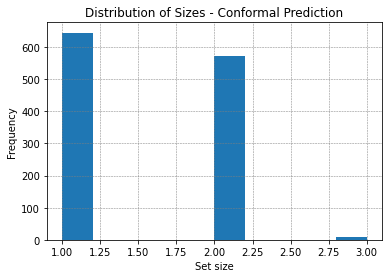

In [ ]:
plt.hist(set_sizes, histtype ='bar')
plt.title("Distribution of Sizes - Conformal Prediction")
plt.xlabel("Set size")
plt.ylabel("Frequency")
plt.grid(True, color = "grey", linewidth = "0.5", linestyle = "--")

### Conclusions on the Conformal Prediction

5 important insights from the previous graph: 

1) We don't consider that the Conformal Prediction spots problems with the score or the model, despite the fact that there are 2 set sizes (1 and 2) that are significantly higher than the other set size (3). One of the reasons for this might me that as we saw in the beginning of the document, classes in dataset are unbalanced as one of the classes is almost non present in the dataset. 

2) It is desirable to have a wider spread of the set sizes. However, it is completely expected that our histogram looks the way it does, since our multi-class classification problem deals with just 3 classes and not a higher number of classes. For this reason, the only possible set sizes we could encounter can be 0,1,2 or 3. However...

3) The set sizes depend on the computed qhat. Now given our $q_{hat}$ and the fact that after the softmax all predictions are probabilities and must therefore be positive and sum up to one, we derive the following 3 cases:

* CASE #1: For $1-q_{hat} > 0.5$ the only set sizes we can obtain are 0 and 1. 
* CASE #2: For $ 0.34 < 1-q_{hat} < 0.5$ we can obtain set sizes of 0, 1 and 2 but it is not possible to obtain a set sizes of 3. 
* CASE #3: For $1-q_{hat} < 0.34$ which the case for the $q_{hat}$ that we computed, we can obtain set sizes of 1, 2 and 3. 

4) This last point is validated by our histogram. Given that our $q_{hat} \approx 0.8$ then $1-q_{hat} \approx 0.2$ and therefore we are in the previously defined Case #3. 

5) Finally, we can spot a relationship between the accuracy of the model and and $q_{hat}$. We expect that:

* A model that achieves high accuracy, will produce low $1 -q_{hat}$. This since if the model has high accuracy is because it usually predicts the correct class i.e the softmax output of the true class is high. This will cause that the conformal scores will be low or near to zero. For this reason, the $q_{hat}$ will be high and the $1 -q_{hat}$ will be low as it will be the quantile of an empirical distribution made up of a lot of small numbers near to zero. 

* A model that achieves low accuracy, will produce high $1 -q_{hat}$. The reason for this is the inverse of the what we have just explained.



### Final checklist

1. Carefully check all code. Insert comments when needed. Search for "TODO" to see if you forgot something.
2. Run everything one final time. *Please do not send me notebooks with errors or cells that are not working.*
3. Upload the completed notebook **before 14/11/2022 23:59** on the Google Classrom page.

### References

[1] Guo, C., Pleiss, G., Sun, Y. and Weinberger, K.Q., 2017. [On calibration of modern neural networks](https://arxiv.org/abs/1706.04599). In *ICML* (pp. 1321-1330). PMLR.

[2] Mukhoti, J., Kulharia, V., Sanyal, A., Golodetz, S., Torr, P. and Dokania, P., 2020. [Calibrating deep neural networks using focal loss](https://proceedings.neurips.cc/paper/2020/hash/aeb7b30ef1d024a76f21a1d40e30c302-Abstract.html). In *Advances in Neural Information Processing Systems*, 33, pp. 15288-15299.

[3] Angelopoulos, A.N. and Bates, S., 2021. [A gentle introduction to conformal prediction and distribution-free uncertainty quantification](https://arxiv.org/abs/2107.07511). *arXiv preprint arXiv:2107.07511*.